# Training multi-layer perceptron classifiers on probes of differential expression
This notebook attempts a hyperparameter search via cross-validation and the hyeropt hyperparameter optimization library's *tree parzen estimator* algorithm. Altogether four different sets of training/training data from the original microarray data are have MLP classifiers trained over them. Each set of data contains genes differentially expressed in Alzheimer's and Non-diseased samples to varying degrees of significance as determined by a Z-score test detailed in the *Dimensionality Reduction via Z test* notebook. The number of probes in each set and corresponding signiicance threshold used are:

1. 877 probes at significance threshold of 10E-12 
2. 612 probes at significance threshold of 10E-13 
3. 400 probes at significance threshold of 10E-14 
4. 266 probes at significance threshold of 10E-15 

Standardized probe intensities are the features on which the neural networks classify. 

In [80]:
# Include Everything
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from hyperopt import hp, Trials, fmin, tpe, space_eval, STATUS_OK, STATUS_FAIL
from timeit import default_timer as timer
from statistics import mean

from matplotlib import pyplot as plt

import seaborn as sns

In [43]:
fug = pd.read_csv("../Data/877_most_differentially_expressed_probes.csv")
fug 

,Sample_ID,ILMN_2136495,ILMN_1743371,ILMN_1763852,ILMN_1654468,ILMN_1752269,ILMN_1798254,ILMN_1697585,ILMN_1763344,ILMN_2224833,...,ILMN_1752380,ILMN_2075818,ILMN_1717094,ILMN_1785926,ILMN_1671048,ILMN_2155322,ILMN_1708632,ILMN_1713706,ILMN_1685547,target
0,ND_1_08-81,-0.608484,-0.282528,1.878338,0.068580,1.993616,1.028705,1.733322,0.665432,2.130308,...,0.949816,1.520210,-0.145247,0.951325,0.795042,3.908857,0.825246,2.753424,-0.235293,0
1,ND_2_08-85,-0.450478,-0.446540,1.676289,0.178943,1.609101,0.664178,0.779898,-0.454899,2.006701,...,0.554956,1.626860,-0.162695,1.296031,0.932470,4.302290,2.218657,3.558534,0.214640,0
2,ND_4_08-72,-0.499331,-0.294920,1.528959,-0.074855,1.512400,1.191484,1.673209,0.224699,2.491428,...,1.189312,1.556268,-0.151121,1.153712,0.846731,3.881273,1.427993,2.839984,-0.209460,0
3,ND_5_08-83,-0.446970,-0.253692,1.096662,0.018820,1.374569,1.746544,1.768942,1.217734,1.568029,...,0.559434,1.327720,-0.245096,0.613352,0.727741,3.582968,0.316391,2.272174,-0.192632,0
4,ND_6_97-53,-0.554702,-0.333040,0.802514,0.034257,1.036754,2.416969,2.102224,0.829338,1.311762,...,0.306003,1.010647,-0.286675,0.400215,0.531754,3.339232,0.050861,1.814110,-0.078861,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,ND_22_99-02,-0.598405,-0.368472,1.202422,-0.071363,0.608990,2.131229,1.910160,0.700503,1.938139,...,0.108368,0.880268,-0.444921,0.842873,0.202527,3.038014,-0.121233,1.579641,-0.091985,0
191,ND_17_97-14,-0.520588,-0.229578,2.172597,-0.111093,1.505324,1.449591,1.477915,0.007209,2.378719,...,0.640690,1.285788,-0.180810,1.345920,0.481744,3.725214,0.570984,2.663690,-0.116887,0
192,ND_23_98-22,-0.530727,-0.465578,1.204023,0.218292,1.194210,1.696750,1.996917,0.228741,1.808107,...,0.304763,1.091547,-0.318011,0.772597,0.214372,3.378949,0.006169,2.084441,-0.035391,0
193,ND_18_97-37,-0.537585,-0.401596,0.559324,-0.165390,0.757197,2.434575,1.965859,1.007047,1.172783,...,0.024157,1.016893,-0.338750,0.402214,0.216171,2.893704,-0.101159,1.562964,0.064384,0


In [72]:
# Generate training and testing data splits for each of the different number of features
data = dict()
feature_sizes = "877 612 400 266".split(" ")


for n_feats in feature_sizes:
    n_feats_data = pd.read_csv(f"../Data/{n_feats}_most_differentially_expressed_probes.csv")
    sample_cols = n_feats_data.columns[1:len(n_feats_data.columns) -1]
    # 80/20 train test split
    train, test = train_test_split(n_feats_data, train_size=0.8, random_state=23)
    # Add the training and test data frames to the data dictionary, without tatget column
    data[f"{n_feats}_train"] = train.loc[:, sample_cols]
    data[f"{n_feats}_test"] = test.loc[:, sample_cols]
    # Save target columns for train/test data in the data dictionary as separate series
    data[f"{n_feats}_train_lbls"] = train["target"]
    data[f"{n_feats}_test_lbls"] = test["target"]


In [ ]:
# Define the search space. Dictionaries are in key:value where the value is a probabilistic space to 
# "randomly" chose from (I believe as TPE algorithm works, it changes updates probabilistic distributions)
# The tree structure formed by this dictionary is the tree refered to in TPE
search_space =  hp.choice("layers", [
    {
        "type": "two_layer",
        "k": hp.quniform("2layers_k",1,7,1), # k is selecting for bias alpha, where alpha = 10^-k [0.1, 0.01, ... 10^-7]
        "l1": hp.qnormal("2layers_l1",150, 65, 1), # Discretized normal dist, mu =150, stdev=65
        "l2": hp.qnormal("2layers_l2",75, 32, 1), #  mu =75, stdev=32
    },
    {
        "type": "three_layer",
        "k": hp.uniform("3layers_k",1,7),
        "l1": hp.qnormal("3layers_l1",150, 65, 1), # Discretized normal dist, mu =150, stdev=65
        "l2": hp.qnormal("3layers_l2",75, 32, 1), # mu =75, stdev=32
        "l3": hp.qnormal("3layers_l3",40, 20, 1), # Discretized normal dist, mu =75, stdev=32
    }
])


# Define the optimization function (Costly to run as it implies fitting a MLP classifier via CV)
def objective(architecture):
    """ The objective function to optimize is the 5-fold cross-validation fitting of a 2 hidden layer NN classifier.
        The hyperoptimizer operates as a minimizer, so the returned loss will be the negative of the avg of 
        mean accuracy.
    """
    # Determine classifer hyperparams from architecture dictionary given
    if "l3" in architecture:
        shape = (2, int(architecture["l1"]), int(architecture["l2"]), int(architecture["l3"]))
    else:
        shape = (2, int(architecture["l1"]), int(architecture["l2"]))
    k = architecture["k"]
    
    # Make a new MLP Classifier
    cfier = MLPClassifier(max_iter=300, hidden_layer_sizes=shape, solver= "lbfgs", alpha = pow(10, -k))
    
    # Cross Validatae
    results = cross_validate(cfier, X=train_data, y=train_lbls, cv=5, n_jobs=-1)
    # Results must contain a "loss" value for hyperopt to minimize, and the status
    results["loss"] = -1 * mean(results["test_score"]) 
    del results["test_score"]
    # For brevity report means
    results["fit_time"] = mean(results["fit_time"])
    results["score_time"] = mean(results["score_time"])
    results["status"] = STATUS_OK
    
    return results



## Use hyperopt to optimize hyperarameters for MLP classifiers different feature sets
Optimize over the four different feature sets of varying significance selection thresholds. Record the best performer for each, as well as the trials results for the hyperparameter search in the performance dictionary for later visualization. 

In [131]:
performance = dict()

for nfeats in feature_sizes:
    # How many features is this model to be trained over?  
    train_data = data[f"{nfeats}_train"]
    train_lbls = data[f"{nfeats}_train_lbls"]

    # Create a trials Hyperopt Object which stores data regarding the results of our hyperparameter search
    trials = Trials()

    # Run the hyperparam search. We'll let the hyperopt lib suggest the tpe to use
    best_performer = fmin(fn=objective, space=search_space, algo=tpe.suggest, trials=trials, max_evals=750, 
                            rstate= np.random.RandomState(32))
    
    # Add results to the dictionary
    performance[f"{nfeats}_best"] = best_performer
    mean_acc = [-1 * res['loss'] for res in trials.results]
    fit_time = [res['fit_time'] for res in trials.results]
    performance[f"{nfeats}_mean_acc"] = mean_acc 
    performance[f"{nfeats}_fit_time"] =  fit_time

100%|██████████| 750/750 [01:16<00:00,  9.75trial/s, best loss: -0.8205645161290323]


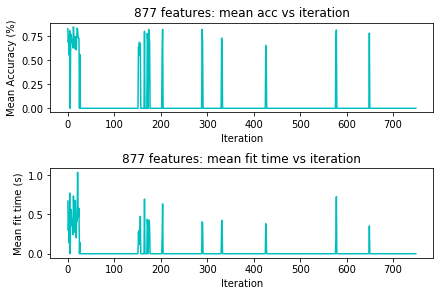

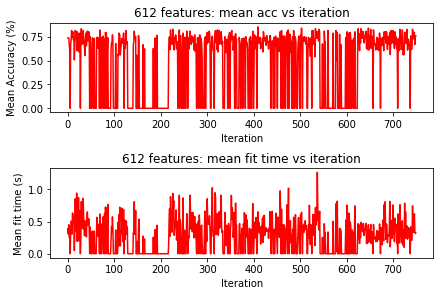

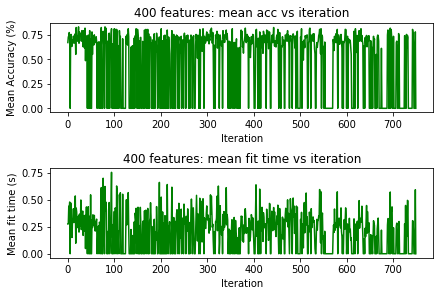

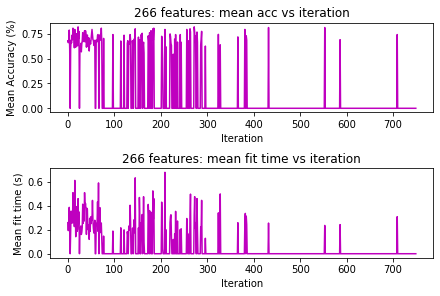

In [136]:
# Report the results and visualize the training progress of mean accuracy and iteration 

figs = []
axes = []
colors = ["c", "r", "g", "m"]

for i, nfeats in enumerate(feature_sizes):
    """
    best = performance[f"{nfeats}_best"]
    layers = best["layers"] + 2
    alpha = pow(10, -1*best[f"{layers}layers_k"])
    l1_neurons = best[f"{layers}layers_l1"]
    l2_neurons = best[f"{layers}layers_l2"]
    print(f"Best performer for {nfeats} features:\n")
    print(f"\tlayers: {layers}")
    print(f"\talpha: {alpha}")
    print(f"\tl1 neurons: {l1_neurons}")
    print(f"\tl2 neurons: {l2_neurons}")
    if layers == 3:
        l3_neurons = best[f"{layers}layers_l3"]
        print(f"\tl3 neurons: {l3_neurons}")
    """
    
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    mean_acc = pd.Series(performance[f"{nfeats}_mean_acc"]).fillna(value=0) # Replace NaNs with 0's
    axs[0].plot(mean_acc, c=colors[i])
    axs[0].set_title(f"{nfeats} features: mean acc vs iteration")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Mean Accuracy (%)")
    axs[1].plot(performance[f"{nfeats}_fit_time"], c=colors[i])
    axs[1].set_title(f"{nfeats} features: mean fit time vs iteration")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Mean fit time (s)")
    
    figs.append(fig)
    axes.append(axs)

In [126]:
fit_time

[-0.2913974761962891,
 -0.3091581344604492,
 -0.3997157096862793,
 -0.21645941734313964,
 -0.30291171073913575,
 -0.0008815765380859375,
 -0.435959529876709,
 -0.47709455490112307,
 -0.4273657321929932,
 -0.15535225868225097,
 -0.4148880481719971,
 -0.41634502410888674,
 -0.3163455963134766,
 -0.33161535263061526,
 -0.46515750885009766,
 -0.12596793174743653,
 -0.5786282539367675,
 -0.44101781845092775,
 -0.32310471534729,
 -0.588511848449707,
 -0.16202611923217775,
 -0.0008449077606201172,
 -0.000772857666015625,
 -0.0007950782775878907,
 -0.0008271217346191406,
 -0.0008413314819335938,
 -0.08862481117248536,
 -0.19125547409057617,
 -0.0009816646575927734,
 -0.25938005447387696,
 -0.30388312339782714,
 -0.0008603572845458984,
 -0.00075836181640625,
 -0.0007726192474365234,
 -0.0007838726043701172,
 -0.0007802009582519531,
 -0.0007747173309326172,
 -0.0007681369781494141,
 -0.0008084297180175782,
 -0.0008451461791992188,
 -0.0008296966552734375,
 -0.0008776187896728516,
 -0.00073828697

In [107]:
cfier = MLPClassifier(max_iter=300, hidden_layer_sizes=(2,117, 67), solver= "lbfgs", alpha = pow(10, -2))
cfier.fit(X=data["400_train"], y=data["400_train_lbls"])

MLPClassifier(alpha=0.01, hidden_layer_sizes=(2, 117, 67), max_iter=300,
              solver='lbfgs')

In [108]:
predictions = cfier.predict(data["400_test"])
cf = confusion_matrix(data["400_test_lbls"], predictions)
print(cf)

[[21  0]
 [ 0 18]]


In [92]:
f3.set_autoscalex_on
f3.set_autoscaley_on

<bound method _AxesBase.set_autoscaley_on of <matplotlib.axes._subplots.AxesSubplot object at 0x7f05447820d0>>